In [1]:
import os, sys
import numpy as np
from matplotlib import pyplot as plt

import pandas as pd

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder

from keras.models import Sequential, Model
# from keras.layers import Input, Embedding, Reshape, merge, LSTM, Bidirectional
# from keras.layers import TimeDistributed, Activation, SimpleRNN, GRU
from keras.layers.core import Flatten, Dense, Dropout, Lambda
#from keras.regularizers import l2, activity_l2, l1, activity_l1
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from utils import *
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Init some useful dirs

current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir+'/data/'

#Set path to sample/ path if desired
test_path = DATA_HOME_DIR + ''
results_path=DATA_HOME_DIR + 'results/'
train_path=DATA_HOME_DIR + ''

## Data

In [3]:
df_train = pd.read_csv(train_path+"application_train.csv")
df_test  = pd.read_csv(test_path+"application_test.csv")

In [ ]:
# Fill in some blanks first
df_train['EXT_SOURCE_1'] = df_train['EXT_SOURCE_1'].fillna(0)
df_train['EXT_SOURCE_2'] = df_train['EXT_SOURCE_2'].fillna(0)
df_train['EXT_SOURCE_3'] = df_train['EXT_SOURCE_3'].fillna(0)

### Training

In [32]:
pd.options.display.max_columns = None

In [33]:
df_train.sample(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
216271,350590,0,Cash loans,F,Y,Y,2,202500.0,270000.0,18396.0,270000.0,Family,Working,Higher education,Civil marriage,House / apartment,0.010006,-10698,-444,-4881.0,-2231,17.0,1,1,1,1,1,0,Accountants,4.0,2,1,SUNDAY,11,0,0,0,0,0,0,Security,0.261542,0.098357,0.237916,0.0670,0.0661,0.9821,0.7552,0.0091,0.00,0.1379,0.1667,0.2083,0.0898,0.0546,0.0623,0.0000,0.0000,0.0683,0.0686,0.9821,0.7648,0.0092,0.0000,0.1379,0.1667,0.2083,0.0918,0.0597,0.0649,0.0000,0.0000,0.0677,0.0661,0.9821,0.7585,0.0091,0.00,0.1379,0.1667,0.2083,0.0913,0.0556,0.0634,0.0000,0.0000,reg oper account,block of flats,0.0529,"Stone, brick",No,0.0,0.0,0.0,0.0,-723.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,2.0
45513,152711,0,Cash loans,F,N,N,0,270000.0,675000.0,64089.0,675000.0,Unaccompanied,Working,Secondary / secondary special,Separated,House / apartment,0.032561,-19053,-176,-6426.0,-2590,NaN,1,1,1,1,1,0,Laborers,1.0,1,1,FRIDAY,18,0,0,0,0,0,0,Other,0.738786,0.754552,0.130947,0.2443,0.1175,0.9881,0.8368,0.0824,0.24,0.1034,0.6250,0.6667,0.0480,0.1984,0.2884,0.0039,0.0027,0.2489,0.1220,0.9881,0.8432,0.0831,0.2417,0.1034,0.6250,0.6667,0.0491,0.2167,0.3005,0.0039,0.0029,0.2467,0.1175,0.9881,0.8390,0.0829,0.24,0.1034,0.6250,0.6667,0.0488,0.2018,0.2936,0.0039,0.0028,reg oper spec account,block of flats,0.2286,Panel,No,0.0,0.0,0.0,0.0,-709.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
23138,126924,0,Cash loans,F,Y,Y,0,247500.0,900000.0,46084.5,900000.0,Unaccompanied,State servant,Higher education,Single / not married,House / apartment,0.015221,-23048,-8031,-13595.0,-3087,7.0,1,1,0,1,1,0,Core staff,1.0,2,2,WEDNESDAY,15,0,0,0,0,0,0,School,0.825766,0.588906,0.740799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [34]:
df_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.114231,0.087543,0.977065,0.759637,0.042553,0.074490,0.145193,0.222315,0.228058,0.064958,0.105645,0.105975,0.008076,0.027022,0.117850,0.087955,0.97

In [4]:
list(df_train.columns)

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_A

In [6]:
df_train[['TARGET', 'SK_ID_CURR']].groupby(['TARGET']).agg(['count'])

,SK_ID_CURR
,count
TARGET,
0,282686
1,24825


In [ ]:
df_train[['TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL','AMT_CREDIT', 'AMT_ANNUITY']].groupby(['TARGET']).agg(['count', 'mean'])

In [7]:
df_train_y = df_train[['TARGET']]

Plot the histrogram Of some of the money fields to see the distributions 

In [35]:
def plot_hist(in_df, in_upper=None):
    if in_upper: 
       in_df = in_df.clip(0, in_upper) # Remove some of the outliers
    in_df.hist(bins=50)

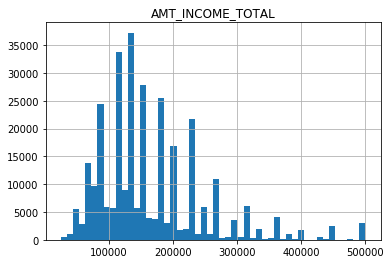

In [22]:
plot_hist(df_train[['AMT_INCOME_TOTAL']], 500000)

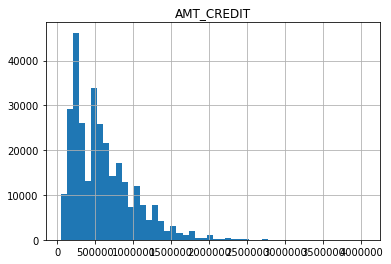

In [24]:
plot_hist(df_train[['AMT_CREDIT']], 10000000)

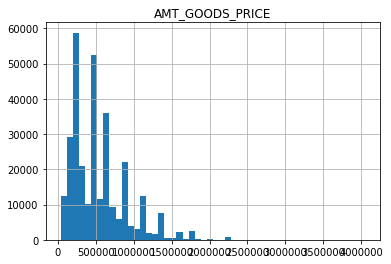

In [25]:
plot_hist(df_train[['AMT_GOODS_PRICE']], 10000000)

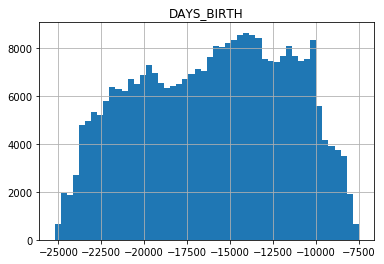

In [36]:
plot_hist(df_train[['DAYS_BIRTH']])

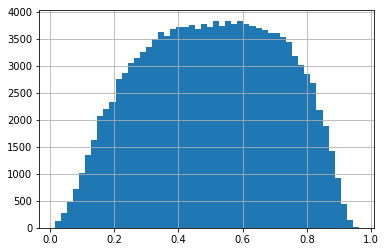

In [37]:
plot_hist(df_train['EXT_SOURCE_1'])

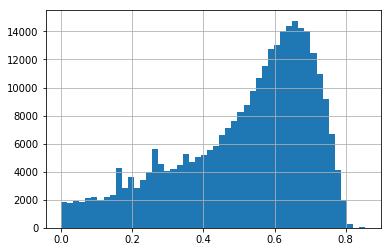

In [38]:
plot_hist(df_train['EXT_SOURCE_2'])

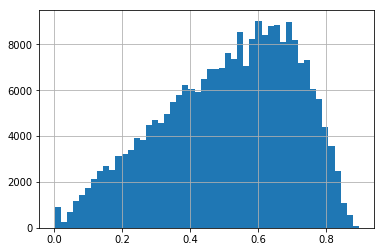

In [39]:
plot_hist(df_train['EXT_SOURCE_3'])

### Correlations
First lets look at the correlation with the target. This should help us isolate the important features

In [55]:
corrs = df_train.corr()

In [56]:
corrs = corrs.sort_values('TARGET', ascending = False)
# Ten most positive correlations
pd.DataFrame(corrs['TARGET'].head(10))

,TARGET
TARGET,1.000000
DAYS_BIRTH,0.078239
REGION_RATING_CLIENT_W_CITY,0.060893
REGION_RATING_CLIENT,0.058899
DAYS_LAST_PHONE_CHANGE,0.055218
DAYS_ID_PUBLISH,0.051457
REG_CITY_NOT_WORK_CITY,0.050994
FLAG_EMP_PHONE,0.045982
REG_CITY_NOT_LIVE_CITY,0.044395
FLAG_DOCUMENT_3,0.044346


In [57]:
# Ten most negative correlations
pd.DataFrame(corrs['TARGET'].dropna().tail(10))

,TARGET
ELEVATORS_AVG,-0.034199
REGION_POPULATION_RELATIVE,-0.037227
AMT_GOODS_PRICE,-0.039645
FLOORSMAX_MODE,-0.043226
FLOORSMAX_MEDI,-0.043768
FLOORSMAX_AVG,-0.044003
DAYS_EMPLOYED,-0.044932
EXT_SOURCE_1,-0.064698
EXT_SOURCE_3,-0.119572
EXT_SOURCE_2,-0.159030


The correlation between EXT_SOURCE_1 and the TARGET is -0.0647
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


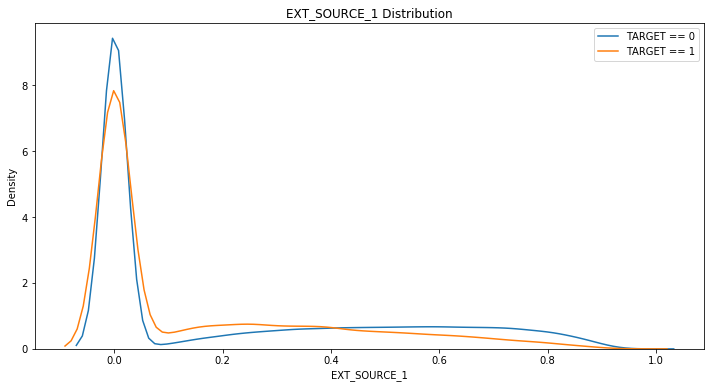

In [51]:
kde_target('EXT_SOURCE_1', df_train)

The correlation between EXT_SOURCE_2 and the TARGET is -0.1590
Median value for loan that was not repaid = 0.4395
Median value for loan that was repaid =     0.5734


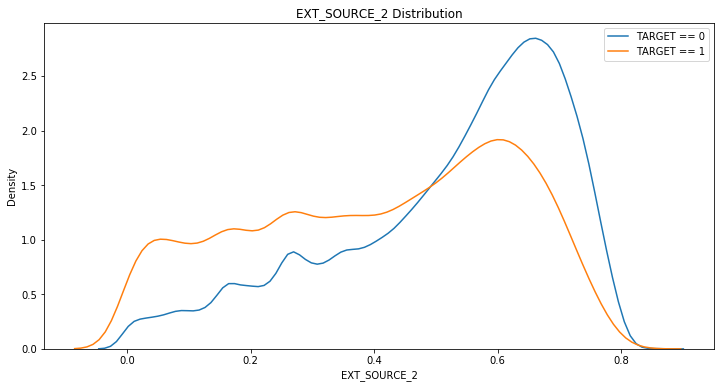

In [50]:
kde_target('EXT_SOURCE_2', df_train)

The correlation between EXT_SOURCE_3 and the TARGET is -0.1196
Median value for loan that was not repaid = 0.2881
Median value for loan that was repaid =     0.4741


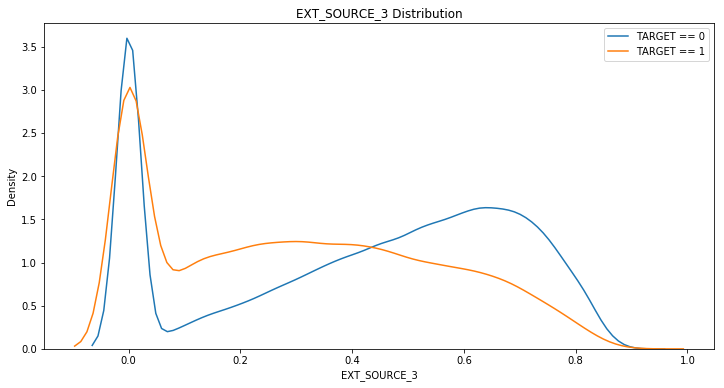

In [52]:
kde_target('EXT_SOURCE_3', df_train)

## Feature Engineering

### Categrical data
First lets get the subset of columns to one hot  encode

In [8]:
# Utility to add missing dummies in test set
def fix_missing_cols(in_train, in_test):
    missing_cols = set( in_train.columns ) - set( in_test.columns )
    # Add a missing column in test set with default value equal to 0
    for c in missing_cols:
        in_test[c] = 0
    # Ensure the order of column in the test set is in the same order than in train set
    in_test = in_test[in_train.columns]
    return in_test

In [9]:
categorical_cols = ['SK_ID_CURR',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE'
]


and now one hot encode. Ideally this would cover all the variations in the underlying data set (not just from the sample)

In [10]:
df_train_enc = pd.get_dummies(df_train[categorical_cols])

In [11]:
df_train_enc.shape

(307511, 42)

In [16]:
x_train, x_test, y_train, y_test = train_test_split( df_train_enc, df_train_y, test_size=0.2, random_state=42)

In [17]:
x_train.shape

(246008, 42)

In [18]:
y_train.shape

(246008, 1)

### Numerical data

In [44]:
df_num = df_train[['AMT_INCOME_TOTAL']]
x_norm = preprocessing.scale(df_num)
df_num['AMT_INCOME_TOTAL'] = x_norm
df_num.describe()

c:\users\lsmith\appdata\local\conda\conda\envs\homecredit\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,AMT_INCOME_TOTAL
count,3.075110e+05
mean,-1.590866e-17
std,1.000002e+00
min,-6.036870e-01
25%,-2.374210e-01
50%,-9.129414e-02
75%,1.421293e-01
max,4.927034e+02


## Model Setup

In [34]:
in_layers = 42
fd_layers = in_layers*2
learning_rate = 0.1

In [37]:
model = Sequential()
model.add(Dense(fd_layers, input_dim=in_layers, activation='relu'))
model.add(Dense(int((fd_layers/2)), activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['accuracy'])

In [21]:
batch_size=64

In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 84)                3612      
_________________________________________________________________
dense_17 (Dense)             (None, 42)                3570      
_________________________________________________________________
batch_normalization_2 (Batch (None, 42)                168       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 43        
Total params: 7,393
Trainable params: 7,309
Non-trainable params: 84
_________________________________________________________________


In [23]:
from roc_callback import *
roc_cb = roc_callback(training_data=(x_train, y_train),validation_data=(x_test, y_test))

In [39]:
model.fit(x_train, y_train, epochs=10, batch_size=batch_size, callbacks=[roc_cb])

Epoch 1/10
246008/246008 [==============================] - 7s 27us/step - loss: 0.2854 - acc: 0.9191
roc-auc: 0.4979 - roc-auc_val: 0.4974                                                                                                    
Epoch 2/10
246008/246008 [==============================] - 6s 24us/step - loss: 0.2839 - acc: 0.9192
roc-auc: 0.5 - roc-auc_val: 0.5                                                                                                    
Epoch 3/10
246008/246008 [==============================] - 6s 25us/step - loss: 0.2840 - acc: 0.9192
roc-auc: 0.5 - roc-auc_val: 0.5                                                                                                    
Epoch 4/10
246008/246008 [==============================] - 6s 24us/step - loss: 0.2833 - acc: 0.9192
roc-auc: 0.5 - roc-auc_val: 0.5                                                                                                    
Epoch 5/10
246008/246008 [==============================] 

In [40]:
model.optimizer.lr = 0.01

In [41]:
model.fit(x_train, y_train, epochs=5, batch_size=batch_size, callbacks=[roc_cb])

Epoch 1/5
246008/246008 [==============================] - 6s 26us/step - loss: 0.2838 - acc: 0.9192
roc-auc: 0.5 - roc-auc_val: 0.5                                                                                                    
Epoch 2/5
246008/246008 [==============================] - 6s 26us/step - loss: 0.2839 - acc: 0.9192
roc-auc: 0.5 - roc-auc_val: 0.5                                                                                                    
Epoch 3/5
246008/246008 [==============================] - 6s 26us/step - loss: 0.2844 - acc: 0.9192
roc-auc: 0.5 - roc-auc_val: 0.5                                                                                                    
Epoch 4/5
246008/246008 [==============================] - 6s 26us/step - loss: 0.2842 - acc: 0.9192
roc-auc: 0.5 - roc-auc_val: 0.5                                                                                                    
Epoch 5/5
246008/246008 [==============================] - 6s 26us/s